# Objective: Simple RNN Model Using Synthetic Sine Wave Data
Here, I'm going to build a simple recurrent neural network model using synthetic sine wave data for time series prediction.

In [44]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

## Load Data
This covers how to create the original data.

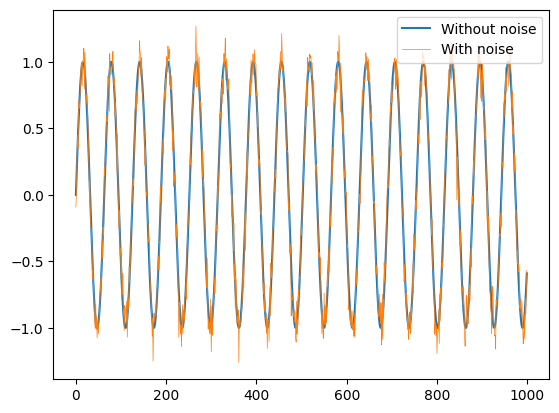

In [45]:
# make the original data
num_data = 1000
series = np.sin(0.1*np.arange(num_data))
series_noise = np.sin(0.1*np.arange(num_data)) + (0.1 * np.random.randn(num_data))

# plot the data
plt.plot(series, label='Without noise')
plt.plot(series_noise, label='With noise', linewidth=0.5)
plt.legend(loc='best')
plt.show()

## Preprocess Data
This covers how to create dataset for training out of the original data.

In [46]:
# build the dataset
T = 10
X = []
Y = []
X_noise = []
Y_noise = []

for t in range(len(series) - T):
    x = series[t:t + T]
    X.append(x)
    y = series[t + T]
    Y.append(y)
    x_noise = series_noise[t:t + T]
    X_noise.append(x_noise)
    y_noise = series_noise[t + T]
    Y_noise.append(y_noise)
    
# convert the data to numpy array and
# reshape the data for the simple rnn model
X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)
X_noise = np.array(X_noise).reshape(-1, T, 1)
Y_noise = np.array(Y_noise).reshape(-1, 1)
N = len(X)

# print out important parameters
print(f"X.shape: {X.shape}, Y.shape: {Y.shape}")
print(f"X_noise.shape: {X_noise.shape}, Y_noise.shape: {Y_noise.shape}")
print(f"N: {N}, T: {T}, D: {D}")

X.shape: (990, 10, 1), Y.shape: (990, 1)
X_noise.shape: (990, 10, 1), Y_noise.shape: (990, 1)
N: 990, T: 10, D: 1


In [47]:
# split dataset into train set and test set
X_train = torch.from_numpy(X[:N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:N//2].astype(np.float32))
X_test = torch.from_numpy(X[N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[N//2:].astype(np.float32))

X_noise_train = torch.from_numpy(X_noise[:N//2].astype(np.float32))
y_noise_train = torch.from_numpy(Y_noise[:N//2].astype(np.float32))
X_noise_test = torch.from_numpy(X_noise[N//2:].astype(np.float32))
y_noise_test = torch.from_numpy(Y_noise[N//2:].astype(np.float32))

## Build Model
This covers how to build a simple recurrent neural network model for time series data synthetically created from sine wave.

In [48]:
# activate gpu if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [49]:
# simple rnn model
class SimpleRNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(SimpleRNN, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        self.rnn = nn.RNN(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            nonlinearity='relu',
            batch_first=True    
        )
        # batch_size=True
        # this applies the convention that the data shape is:
        # (num_samples N, sequence_length T, num_features D)
        # rather than:
        # (sequence_length T, num_samples N, num_features D)
        self.fc = nn.Linear(self.M, self.K)
    
    def forward(self, X):
        # initial hidden states - (L X N X M)
        # X is (N X T X D)
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        
        # get simple rnn unit output
        out, _ = self.rnn(X, h0)
        # out shape is (N, T, M)
        # out is the hidden state for the final layer at each time step
        # _ shape is (L, T, M)
        # _ is he hidden states over all hidden layer but only at the final time step
        
        # get output using the final time step hidden layer
        out = self.fc(out[:, -1, :])
        
        return out

In [50]:
# instantiate the model
model = SimpleRNN(n_inputs=1, n_hidden=15, n_rnnlayers=1, n_outputs=1)

In [51]:
# send the model details and data to the device
model.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
X_noise_train, y_noise_train = X_noise_train.to(device), y_noise_train.to(device)
X_noise_test, y_noise_test = X_noise_test.to(device), y_noise_test.to(device)

In [52]:
# loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training - Data without Noise
This covers how to train the simple recurrent neural netowrk model with the synthetic sine wave data that we processed.

In [53]:
# training
def full_gd(model, criterion, optimizer,
            X_train, y_train, X_test, y_test, epochs=1000):
    # losses will be stored to plot the results
    # storage for losses per each epoch
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for epoch in range(epochs):
        # zero the parameter gradients to make sure they are zero
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        # backward and optimize
        loss.backward()
        optimizer.step()
        
        # save loss
        train_losses[epoch] = loss.item()
        
        ## test
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[epoch] = test_loss.item()
        
        # print out the result
        print(f"Epoch {epoch+1}/{epochs}, Train loss: {loss.item():.4f}, Test loss: {test_loss.item():.4f}")
        
    return train_losses, test_losses

In [54]:
# get the result
train_losses, test_losses = full_gd(model, criterion, optimizer,
                                    X_train, y_train, X_test, y_test)

Epoch 1/1000, Train loss: 0.3910, Test loss: 0.3892
Epoch 2/1000, Train loss: 0.3865, Test loss: 0.3847
Epoch 3/1000, Train loss: 0.3820, Test loss: 0.3801
Epoch 4/1000, Train loss: 0.3775, Test loss: 0.3755
Epoch 5/1000, Train loss: 0.3729, Test loss: 0.3708
Epoch 6/1000, Train loss: 0.3684, Test loss: 0.3661
Epoch 7/1000, Train loss: 0.3637, Test loss: 0.3614
Epoch 8/1000, Train loss: 0.3591, Test loss: 0.3566
Epoch 9/1000, Train loss: 0.3544, Test loss: 0.3518
Epoch 10/1000, Train loss: 0.3496, Test loss: 0.3470
Epoch 11/1000, Train loss: 0.3448, Test loss: 0.3421
Epoch 12/1000, Train loss: 0.3400, Test loss: 0.3371
Epoch 13/1000, Train loss: 0.3350, Test loss: 0.3321
Epoch 14/1000, Train loss: 0.3301, Test loss: 0.3270
Epoch 15/1000, Train loss: 0.3251, Test loss: 0.3219
Epoch 16/1000, Train loss: 0.3200, Test loss: 0.3167
Epoch 17/1000, Train loss: 0.3149, Test loss: 0.3115
Epoch 18/1000, Train loss: 0.3097, Test loss: 0.3061
Epoch 19/1000, Train loss: 0.3044, Test loss: 0.3008
Ep

## Results - Data without Noise
This shows the result of the simple recurrent neural network model by showing the loss evolution.

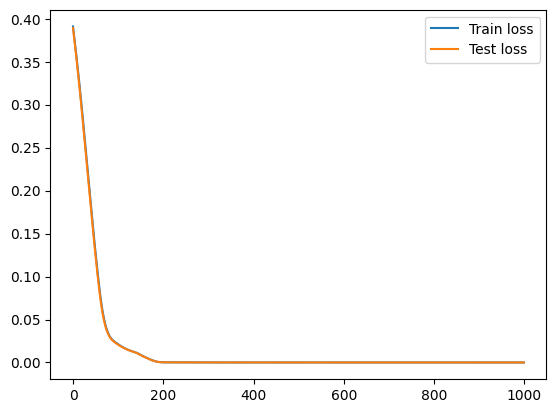

In [55]:
# plot the train loss and test loss per epoch
plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.legend()
plt.show()

## Forecasting - Wrong Method
This is to show how to make wrong prediction by forecasting future values using true future values.

In [57]:
# wrong forecast using true future values
validation_targets = Y[N//2:]   # this is true targets
validation_predictions = []     # this stores predictions

# save predictions using true future values
i = 0
while len(validation_predictions) < len(validation_targets):
    input_ = X_test[i].reshape(1, T, 1)
    p = model(input_)[0, 0].item()
    i += 1
    # store the result in the container
    validation_predictions.append(p)

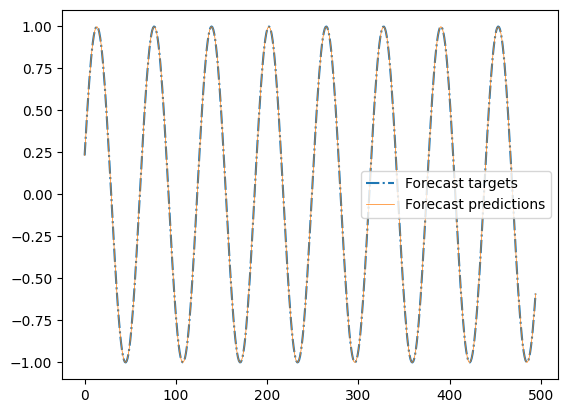

In [58]:
# plot the results
plt.plot(validation_targets, label='Forecast targets',
         linestyle='-.')
plt.plot(validation_predictions, label='Forecast predictions',
         linewidth=0.5)
plt.legend()
plt.show()

## Forecasting - Correct Method
This is to show how to make correct prediction by forecasting future values using future values from our prediction models.

In [93]:
# correct method to get future predictions using previous predictions
validation_targets = Y[N//2:]   # this is true targets
# Y[N//2:] and Y[-N//2:] are same since we have even number of N
validation_predictions = []     # this is container to store predictions

# get the last train data
# which is cat([X_train[-1][1:], y_train[-1])
# this is same as X[-N//2] or X_test[0]
last_X = X_test[0].view(T)      #  

while len(validation_predictions) < len(validation_targets):
    input_ = last_X.reshape(1, T, 1)
    p = model(input_)
    
    # store the result in the container
    validation_predictions.append(p[0, 0].item())
    # update the input including the prediction
    last_X = torch.cat((last_X[1:], p[0]))

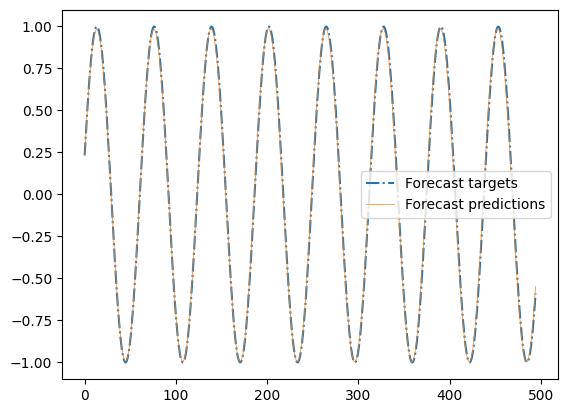

In [94]:
# plot the results
plt.plot(validation_targets, label='Forecast targets',
         linestyle='-.')
plt.plot(validation_predictions, label='Forecast predictions',
         linewidth=0.5)
plt.legend()
plt.show()

## Training - Data with Noise
This covers how to train the simple neural network model with the synthetic sine wave data that we processed.

In [95]:
# get the result
train_losses, test_losses = full_gd(model, criterion, optimizer, X_noise_train, y_noise_train, X_noise_test, y_noise_test)

Epoch 1/1000, Train loss: 0.0152, Test loss: 0.0155
Epoch 2/1000, Train loss: 0.0152, Test loss: 0.0154
Epoch 3/1000, Train loss: 0.0152, Test loss: 0.0154
Epoch 4/1000, Train loss: 0.0152, Test loss: 0.0154
Epoch 5/1000, Train loss: 0.0152, Test loss: 0.0154
Epoch 6/1000, Train loss: 0.0151, Test loss: 0.0153
Epoch 7/1000, Train loss: 0.0151, Test loss: 0.0153
Epoch 8/1000, Train loss: 0.0151, Test loss: 0.0153
Epoch 9/1000, Train loss: 0.0151, Test loss: 0.0153
Epoch 10/1000, Train loss: 0.0150, Test loss: 0.0152
Epoch 11/1000, Train loss: 0.0150, Test loss: 0.0152
Epoch 12/1000, Train loss: 0.0150, Test loss: 0.0152
Epoch 13/1000, Train loss: 0.0150, Test loss: 0.0151
Epoch 14/1000, Train loss: 0.0149, Test loss: 0.0151
Epoch 15/1000, Train loss: 0.0149, Test loss: 0.0151
Epoch 16/1000, Train loss: 0.0149, Test loss: 0.0150
Epoch 17/1000, Train loss: 0.0149, Test loss: 0.0150
Epoch 18/1000, Train loss: 0.0149, Test loss: 0.0150
Epoch 19/1000, Train loss: 0.0148, Test loss: 0.0149
Ep

## Forecasting - Wrong Method
This is to show how to make wrong prediction by forecasting future values using true future values.

In [99]:
# wrong forecast using true future values
validation_targets = Y_noise[N//2:]   # this is true targets
validation_predictions = []     # this stores predictions

# save predictions using true future values
i = 0
while len(validation_predictions) < len(validation_targets):
    input_ = X_noise_test[i].reshape(1, T, 1)
    p = model(input_)[0, 0].item()
    i += 1
    # store the result in the container
    validation_predictions.append(p)

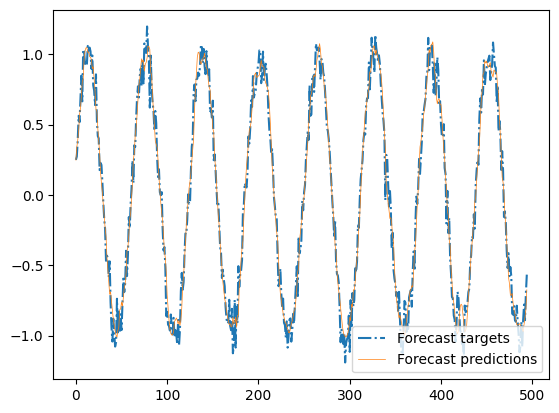

In [100]:
# plot the results
plt.plot(validation_targets, label='Forecast targets',
         linestyle='-.')
plt.plot(validation_predictions, label='Forecast predictions',
         linewidth=0.5)
plt.legend()
plt.show()

## Forecasting - Correct Method
This is to show how to make correct prediction by forecasting future values using future values from our prediction models.

In [101]:
# correct method to get future predictions using previous predictions
validation_targets = Y_noise[N//2:]   # this is true targets
# Y[N//2:] and Y[-N//2:] are same since we have even number of N
validation_predictions = []     # this is container to store predictions

# get the last train data
# which is cat([X_train[-1][1:], y_train[-1])
# this is same as X[-N//2] or X_test[0]
last_X = X_noise_test[0].view(T)      
# !! Need to think about why only this one works for the while loop 

while len(validation_predictions) < len(validation_targets):
    input_ = last_X.reshape(1, T, 1)
    p = model(input_)
    
    # store the result in the container
    validation_predictions.append(p[0, 0].item())
    # update the input including the prediction
    last_X = torch.cat((last_X[1:], p[0]))

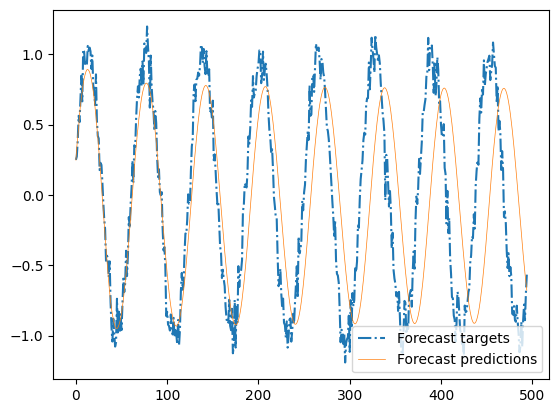

In [102]:
# plot the results
plt.plot(validation_targets, label='Forecast targets',
         linestyle='-.')
plt.plot(validation_predictions, label='Forecast predictions',
         linewidth=0.5)
plt.legend()
plt.show()

# Conclusion
Simple RNN model does predict better than autoregressive linear model for sine wave. However, the frequency information can get lost over time.